# Notebook N03 – Haltestellenkarte und mittlere Verspätung (Züge, Schweiz)

Ziel dieses Notebooks:
- Konzentration auf Zugverkehr (PRODUKT_ID = "Zug")
- Aggregation der Verspätung pro Haltestelle (BPUIC + Name)
- Join mit Haltestellen-Koordinaten
- Visualisierung: Punktkarte der Schweiz, eingefärbt nach mittlerer Ankunftsverspätung

In [ ]:
# %% setup path for imports
import sys
from pathlib import Path

project_root = Path().resolve().parents[0]
src_path = project_root / "src"

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from utils import load_parquet_safely

In [1]:
# %%
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path

# Pfad zu eurer Monatsdatei mit BPUIC
data_path = Path("../data/processed/istdata_clean.parquet")

# Lazy Loading: Nur die benötigten Spalten und Filter anwenden, bevor Daten geladen werden
df = pl.scan_parquet(data_path).filter(
    pl.col("PRODUKT_ID") == "Zug"
).collect()

print(f"Datensatz geladen (nur Züge): {df.shape[0]:,} Zeilen × {df.shape[1]} Spalten")
print(df.columns)
df.head(5)

Datensatz geladen (nur Züge): 4,615,140 Zeilen × 12 Spalten
['BETRIEBSTAG', 'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_TEXT', 'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'ABFAHRTSZEIT', 'delay_arrival_s', 'delay_departure_s', 'on_time', 'FAELLT_AUS_TF', 'BPUIC']


shape: (5, 12)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬─────────┬───────────┬─────────┐
│ BETRIEBSTA ┆ BETREIBER_ ┆ PRODUKT_ID ┆ LINIEN_TE ┆ … ┆ delay_dep ┆ on_time ┆ FAELLT_AU ┆ BPUIC   │
│ G          ┆ NAME       ┆ ---        ┆ XT        ┆   ┆ arture_s  ┆ ---     ┆ S_TF      ┆ ---     │
│ ---        ┆ ---        ┆ cat        ┆ ---       ┆   ┆ ---       ┆ bool    ┆ ---       ┆ str     │
│ str        ┆ str        ┆            ┆ str       ┆   ┆ f64       ┆         ┆ bool      ┆         │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═════════╪═══════════╪═════════╡
│ 01.09.2025 ┆ DB ZugBus  ┆ Zug        ┆ IR3       ┆ … ┆ 78.0      ┆ false   ┆ false     ┆ 8503424 │
│            ┆ Regionalve ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ rkehr      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ Alb-…      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│ 01.09.2025 ┆ DB ZugBus  ┆ Zug        ┆ RE3       ┆ … ┆ 1.0       ┆ true    ┆ false     ┆ 8503424 │
│            ┆ Regionalve ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ rkehr      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ Alb-…      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│ 01.09.2025 ┆ DB ZugBus  ┆ Zug        ┆ IR3       ┆ … ┆ 17.0      ┆ true    ┆ false     ┆ 8503424 │
│            ┆ Regionalve ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ rkehr      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ Alb-…      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│ 01.09.2025 ┆ DB ZugBus  ┆ Zug        ┆ RE3       ┆ … ┆ -2.0      ┆ true    ┆ false     ┆ 8503424 │
│            ┆ Regionalve ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ rkehr      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ Alb-…      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│ 01.09.2025 ┆ DB ZugBus  ┆ Zug        ┆ IR3       ┆ … ┆ 20.0      ┆ false   ┆ false     ┆ 8503424 │
│            ┆ Regionalve ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ rkehr      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
│            ┆ Alb-…      ┆            ┆           ┆   ┆           ┆         ┆           ┆         │
└────────────┴────────────┴────────────┴───────────┴───┴───────────┴─────────┴───────────┴─────────┘

In [2]:
# Daten sind bereits gefiltert (nur Züge)
df_trains = df
print(f"Nur Züge: {df_trains.shape[0]:,} Zeilen")

# Verspätungen in Minuten
df_trains = df_trains.with_columns([
    (pl.col("delay_arrival_s") / 60).alias("arr_delay_min"),
    (pl.col("delay_departure_s") / 60).alias("dep_delay_min")
])

# Delta: wie ändert sich die Verspätung an der Station?
df_trains = df_trains.with_columns([
    (pl.col("dep_delay_min") - pl.col("arr_delay_min")).alias("delta_delay_min")
])

# Filter: delta_delay_min zwischen -60 und 60
df_trains = df_trains.filter(
    pl.col("delta_delay_min").is_between(-60, 60)
)

df_trains.select(["BETRIEBSTAG", "HALTESTELLEN_NAME", "BPUIC", "arr_delay_min", "dep_delay_min", "delta_delay_min"]).head(10)

Nur Züge: 4,615,140 Zeilen


shape: (10, 6)
┌─────────────┬───────────────────┬─────────┬───────────────┬───────────────┬─────────────────┐
│ BETRIEBSTAG ┆ HALTESTELLEN_NAME ┆ BPUIC   ┆ arr_delay_min ┆ dep_delay_min ┆ delta_delay_min │
│ ---         ┆ ---               ┆ ---     ┆ ---           ┆ ---           ┆ ---             │
│ str         ┆ str               ┆ str     ┆ f64           ┆ f64           ┆ f64             │
╞═════════════╪═══════════════════╪═════════╪═══════════════╪═══════════════╪═════════════════╡
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 1.9           ┆ 1.3           ┆ -0.6            │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 0.7           ┆ 0.016667      ┆ -0.683333       │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 0.516667      ┆ 0.283333      ┆ -0.233333       │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 0.3           ┆ -0.033333     ┆ -0.333333       │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 1.383333      ┆ 0.333333      ┆ -1.05           │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 3.7           ┆ 2.4           ┆ -1.3            │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 4.783333      ┆ 3.116667      ┆ -1.666667       │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 0.183333      ┆ 0.183333      ┆ 0.0             │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ -0.016667     ┆ 0.25          ┆ 0.266667        │
│ 01.09.2025  ┆ Schaffhausen      ┆ 8503424 ┆ 3.066667      ┆ 2.233333      ┆ -0.833333       │
└─────────────┴───────────────────┴─────────┴───────────────┴───────────────┴─────────────────┘

In [4]:
print(df_trains["delta_delay_min"].describe())
# Polars quantile akzeptiert nur einzelne Werte, daher separat berechnen
print("Quantile:")
for q in [0.01, 0.05, 0.95, 0.99]:
    print(f"  {q}: {df_trains['delta_delay_min'].quantile(q)}")
print(f"Anteil |delta| > 60 min: {(df_trains['delta_delay_min'].abs() > 60).mean()}")

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 4.614856e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.51295    │
│ std        ┆ 1.176836   │
│ min        ┆ -59.833333 │
│ 25%        ┆ 0.1        │
│ 50%        ┆ 0.5        │
│ 75%        ┆ 0.833333   │
│ max        ┆ 60.0       │
└────────────┴────────────┘
Quantile:
  0.01: -1.5166666666666666
  0.05: -0.8333333333333333
  0.95: 1.9833333333333334
  0.99: 3.583333333333333
Anteil |delta| > 60 min: 0.0


In [5]:
# BPUIC konsistent als String
df_trains = df_trains.with_columns([
    pl.col("BPUIC").cast(pl.Utf8)
])

agg_station_day = (
    df_trains
    .group_by(["BETRIEBSTAG", "BPUIC", "HALTESTELLEN_NAME"])
    .agg([
        pl.col("delta_delay_min").mean().alias("mean_delta_delay_min"),
        pl.col("delta_delay_min").count().alias("n_obs")
    ])
)

print("Aggregierte Haltestellen (Kopf):")
print(agg_station_day.head(10))

print("\nVerteilung der Beobachtungszahlen pro Haltestelle:")
print(agg_station_day["n_obs"].describe())

Aggregierte Haltestellen (Kopf):
shape: (10, 5)
┌─────────────┬─────────┬─────────────────────┬──────────────────────┬───────┐
│ BETRIEBSTAG ┆ BPUIC   ┆ HALTESTELLEN_NAME   ┆ mean_delta_delay_min ┆ n_obs │
│ ---         ┆ ---     ┆ ---                 ┆ ---                  ┆ ---   │
│ str         ┆ str     ┆ str                 ┆ f64                  ┆ u32   │
╞═════════════╪═════════╪═════════════════════╪══════════════════════╪═══════╡
│ 24.09.2025  ┆ 8503527 ┆ Buchs-Dällikon      ┆ 0.563111             ┆ 75    │
│ 01.09.2025  ┆ 8502196 ┆ Unterentfelden Post ┆ 0.578431             ┆ 136   │
│ 08.09.2025  ┆ 8503136 ┆ Fischenthal         ┆ 0.136111             ┆ 60    │
│ 15.09.2025  ┆ 8501067 ┆ Givrins             ┆ 1.038941             ┆ 107   │
│ 21.09.2025  ┆ 8500175 ┆ Le Creux-des-Biches ┆ 0.304598             ┆ 29    │
│ 06.09.2025  ┆ 8503089 ┆ Wildpark-Höfli      ┆ 0.298889             ┆ 120   │
│ 24.09.2025  ┆ 8501177 ┆ Bercher             ┆ 0.47623              ┆ 61    │
│ 30

In [6]:
# Station über den ganzen Monat
agg_stations = (
    df_trains
    .group_by(["BPUIC", "HALTESTELLEN_NAME"])
    .agg([
        pl.col("arr_delay_min").mean().alias("mean_arr_delay_min"),
        pl.col("dep_delay_min").mean().alias("mean_dep_delay_min"),
        pl.col("delta_delay_min").mean().alias("mean_delta_delay_min"),
        pl.col("delta_delay_min").count().alias("n_obs")
    ])
)

print("Aggregierte Haltestellen (Monat, Kopf):")
print(agg_stations.head(10))

print("\nVerteilung der Beobachtungszahlen pro Haltestelle (Monat):")
print(agg_stations["n_obs"].describe())

Aggregierte Haltestellen (Monat, Kopf):
shape: (10, 6)
┌─────────┬────────────────────┬───────────────────┬───────────────────┬───────────────────┬───────┐
│ BPUIC   ┆ HALTESTELLEN_NAME  ┆ mean_arr_delay_mi ┆ mean_dep_delay_mi ┆ mean_delta_delay_ ┆ n_obs │
│ ---     ┆ ---                ┆ n                 ┆ n                 ┆ min               ┆ ---   │
│ str     ┆ str                ┆ ---               ┆ ---               ┆ ---               ┆ u32   │
│         ┆                    ┆ f64               ┆ f64               ┆ f64               ┆       │
╞═════════╪════════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪═══════╡
│ 8502216 ┆ Benzenschwil       ┆ 0.848961          ┆ 1.285795          ┆ 0.436834          ┆ 1476  │
│ 8774375 ┆ Tenay-Hauteville   ┆ 2.356608          ┆ 2.34414           ┆ -0.012469         ┆ 401   │
│ 8501488 ┆ Bévieux            ┆ 1.308892          ┆ 1.972321          ┆ 0.663429          ┆ 1014  │
│ 8501468 ┆ Aigle-Château      ┆ 4.1

In [7]:
MIN_OBS = 3000

agg_filtered = agg_stations.filter(pl.col("n_obs") >= MIN_OBS)
print(f"Haltestellen mit mindestens {MIN_OBS} Fahrten: {agg_filtered.shape[0]}")

# Bahnhöfe, die im Mittel am meisten Verspätung ABBauen (delta stark negativ)
best_stations = (
    agg_filtered
    .sort("mean_delta_delay_min")  # stärkste Reduktion zuerst
    .head(30)
)

print("Bahnhöfe, die im Mittel am meisten Verspätung abgebaut haben (delta_delay_min < 0):")
print(
    best_stations.select(["HALTESTELLEN_NAME", "BPUIC", "mean_arr_delay_min", "mean_dep_delay_min", "mean_delta_delay_min", "n_obs"])
)

# Bahnhöfe, die im Mittel am meisten zusätzliche Verspätung erzeugen (delta stark positiv)
worst_stations = (
    agg_filtered
    .sort("mean_delta_delay_min", descending=True)  # stärkste Verschlechterung zuerst
    .head(30)
)

print("\nBahnhöfe, die im Mittel am meisten zusätzliche Verspätung erzeugen (delta_delay_min > 0):")
print(
    worst_stations.select(["HALTESTELLEN_NAME", "BPUIC", "mean_arr_delay_min", "mean_dep_delay_min", "mean_delta_delay_min", "n_obs"])
)

Haltestellen mit mindestens 3000 Fahrten: 453
Bahnhöfe, die im Mittel am meisten Verspätung abgebaut haben (delta_delay_min < 0):
shape: (30, 6)
┌────────────────────┬─────────┬───────────────────┬───────────────────┬───────────────────┬───────┐
│ HALTESTELLEN_NAME  ┆ BPUIC   ┆ mean_arr_delay_mi ┆ mean_dep_delay_mi ┆ mean_delta_delay_ ┆ n_obs │
│ ---                ┆ ---     ┆ n                 ┆ n                 ┆ min               ┆ ---   │
│ str                ┆ str     ┆ ---               ┆ ---               ┆ ---               ┆ u32   │
│                    ┆         ┆ f64               ┆ f64               ┆ f64               ┆       │
╞════════════════════╪═════════╪═══════════════════╪═══════════════════╪═══════════════════╪═══════╡
│ Boudry Tuilière    ┆ 8530713 ┆ 2.647998          ┆ 1.882669          ┆ -0.765329         ┆ 3364  │
│ Auvernier          ┆ 8504510 ┆ 2.283254          ┆ 1.571168          ┆ -0.712087         ┆ 3377  │
│ Littorail          ┆         ┆               

In [8]:
from pathlib import Path

export_cols = [
    "BPUIC",
    "HALTESTELLEN_NAME",
    "mean_arr_delay_min",
    "mean_dep_delay_min",
    "mean_delta_delay_min",
    "n_obs",
]

out_path = Path("../data/processed/station_delta_delays_2025-09_minObs200.csv")
agg_filtered.select(export_cols).write_csv(out_path)

print("Aggregierte Stationskennzahlen gespeichert unter:")
print(out_path)

Aggregierte Stationskennzahlen gespeichert unter:
../data/processed/station_delta_delays_2025-09_minObs200.csv


In [10]:
from pathlib import Path
import polars as pl

stops_path = Path("../data/external/dienststellen.csv")

# Wichtig: sep=';' setzen, damit das Komma in der Geoposition nicht als Spaltentrenner verwendet wird
# In Polars heißt der Parameter 'separator', und schema_overrides muss ein Dict sein
stops = pl.read_csv(stops_path, separator=";")

print(stops.columns)
stops.head()

['lod', 'Geoposition', '\ufeffnumberShort', 'uicCountryCode', 'sloid', 'number', 'validFrom', 'validTo', 'designationOfficial', 'designationLong', 'abbreviation', 'operatingPoint', 'operatingPointWithTimetable', 'stopPoint', 'stopPointType', 'freightServicePoint', 'trafficPoint', 'borderPoint', 'hasGeolocation', 'isoCountryCode', 'cantonName', 'cantonFsoNumber', 'cantonAbbreviation', 'districtName', 'districtFsoNumber', 'municipalityName', 'fsoNumber', 'localityName', 'operatingPointType', 'operatingPointTechnicalTimetableType', 'meansOfTransport', 'categories', 'operatingPointTrafficPointType', 'operatingPointRouteNetwork', 'operatingPointKilometer', 'operatingPointKilometerMasterNumber', 'sortCodeOfDestinationStation', 'businessOrganisation', 'businessOrganisationNumber', 'businessOrganisationAbbreviationDe', 'businessOrganisationAbbreviationFr', 'businessOrganisationDescriptionDe', 'businessOrganisationDescriptionFr', 'fotComment', 'height', 'creationDate', 'editionDate']


shape: (5, 47)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ lod        ┆ Geopositio ┆ ﻿numberSho ┆ uicCountr ┆ … ┆ fotCommen ┆ height ┆ creationD ┆ editionDa │
│ ---        ┆ n          ┆ rt        ┆ yCode     ┆   ┆ t         ┆ ---    ┆ ate       ┆ te        │
│ str        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64    ┆ ---       ┆ ---       │
│            ┆ str        ┆ i64       ┆ i64       ┆   ┆ str       ┆        ┆ str       ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ http://lod ┆ 48.4698600 ┆ 10530     ┆ 11        ┆ … ┆ null      ┆ 0.0    ┆ 2023-04-2 ┆ 2024-04-0 │
│ .opentrans ┆ 10403906,  ┆           ┆           ┆   ┆           ┆        ┆ 8T06:44:2 ┆ 8T11:26:0 │
│ portdata.s ┆ 8.49968000 ┆           ┆           ┆   ┆           ┆        ┆ 6+02:00   ┆ 6+02:00   │
│ …          ┆ …          ┆           ┆           ┆   ┆           ┆        ┆           ┆           │
│ http://lod ┆ 52.2816690 ┆ 10577     ┆ 11        ┆ … ┆ null      ┆ 0.0    ┆ 2023-06-0 ┆ 2024-04-0 │
│ .opentrans ┆ 08914854,  ┆           ┆           ┆   ┆           ┆        ┆ 6T10:32:3 ┆ 8T11:26:0 │
│ portdata.s ┆ 10.5763960 ┆           ┆           ┆   ┆           ┆        ┆ 5+02:00   ┆ 6+02:00   │
│ …          ┆ …          ┆           ┆           ┆   ┆           ┆        ┆           ┆           │
│ http://lod ┆ 53.6983580 ┆ 10609     ┆ 11        ┆ … ┆ null      ┆ 0.0    ┆ 2023-06-2 ┆ 2024-04-0 │
│ .opentrans ┆ 07861174,  ┆           ┆           ┆   ┆           ┆        ┆ 7T10:01:5 ┆ 8T11:26:0 │
│ portdata.s ┆ 10.7416240 ┆           ┆           ┆   ┆           ┆        ┆ 9+02:00   ┆ 6+02:00   │
│ …          ┆ …          ┆           ┆           ┆   ┆           ┆        ┆           ┆           │
│ http://lod ┆ 52.5817612 ┆ 10611     ┆ 11        ┆ … ┆ null      ┆ 0.0    ┆ 2023-06-2 ┆ 2024-04-0 │
│ .opentrans ┆ 0729621,   ┆           ┆           ┆   ┆           ┆        ┆ 7T10:13:4 ┆ 8T11:26:0 │
│ portdata.s ┆ 13.5791740 ┆           ┆           ┆   ┆           ┆        ┆ 1+02:00   ┆ 6+02:00   │
│ …          ┆ 0…         ┆           ┆           ┆   ┆           ┆        ┆           ┆           │
│ http://lod ┆ 50.3701730 ┆ 10563     ┆ 11        ┆ … ┆ null      ┆ 0.0    ┆ 2023-06-0 ┆ 2024-04-0 │
│ .opentrans ┆ 1038644,   ┆           ┆           ┆   ┆           ┆        ┆ 1T17:06:3 ┆ 8T11:26:0 │
│ portdata.s ┆ 8.46894500 ┆           ┆           ┆   ┆           ┆        ┆ 5+02:00   ┆ 6+02:00   │
│ …          ┆ 7…         ┆           ┆           ┆   ┆           ┆        ┆           ┆           │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴────────┴───────────┴───────────┘

In [12]:
# BPUIC als String casten
stops = stops.with_columns([
    pl.col("operatingPointKilometerMasterNumber").cast(pl.Utf8).alias("BPUIC")
])

# Geoposition in lat / lon aufspalten - mit strip() um Leerzeichen zu entfernen
stops = stops.with_columns([
    pl.col("Geoposition").str.split(",").list.get(0).str.strip_chars().cast(pl.Float64).alias("lat"),
    pl.col("Geoposition").str.split(",").list.get(1).str.strip_chars().cast(pl.Float64).alias("lon")
])

stops.select(["BPUIC", "lat", "lon"]).head()

shape: (5, 3)
┌───────┬───────────┬───────────┐
│ BPUIC ┆ lat       ┆ lon       │
│ ---   ┆ ---       ┆ ---       │
│ str   ┆ f64       ┆ f64       │
╞═══════╪═══════════╪═══════════╡
│ null  ┆ 48.46986  ┆ 8.49968   │
│ null  ┆ 52.281669 ┆ 10.576396 │
│ null  ┆ 53.698358 ┆ 10.741624 │
│ null  ┆ 52.581761 ┆ 13.579174 │
│ null  ┆ 50.370173 ┆ 8.468945  │
└───────┴───────────┴───────────┘

In [13]:
# BPUIC-Typ harmonisieren
agg_filtered = agg_filtered.with_columns([
    pl.col("BPUIC").cast(pl.Utf8)
])
stops = stops.with_columns([
    pl.col("BPUIC").cast(pl.Utf8)
])

stops_small = stops.select(["BPUIC", "lat", "lon"]).drop_nulls()

stations_geo = agg_filtered.join(stops_small, on="BPUIC", how="inner")

print("Nach Join:", stations_geo.shape)
stations_geo.head()

Nach Join: (613, 8)


shape: (5, 8)
┌─────────┬──────────────┬──────────────┬─────────────┬─────────────┬───────┬───────────┬──────────┐
│ BPUIC   ┆ HALTESTELLEN ┆ mean_arr_del ┆ mean_dep_de ┆ mean_delta_ ┆ n_obs ┆ lat       ┆ lon      │
│ ---     ┆ _NAME        ┆ ay_min       ┆ lay_min     ┆ delay_min   ┆ ---   ┆ ---       ┆ ---      │
│ str     ┆ ---          ┆ ---          ┆ ---         ┆ ---         ┆ u32   ┆ f64       ┆ f64      │
│         ┆ str          ┆ f64          ┆ f64         ┆ f64         ┆       ┆           ┆          │
╞═════════╪══════════════╪══════════════╪═════════════╪═════════════╪═══════╪═══════════╪══════════╡
│ 8500126 ┆ Porrentruy   ┆ 0.439655     ┆ 0.858292    ┆ 0.418637    ┆ 3857  ┆ 47.420916 ┆ 7.080077 │
│ 8500109 ┆ Delémont     ┆ 0.846741     ┆ 1.050126    ┆ 0.203386    ┆ 3702  ┆ 47.362013 ┆ 7.350063 │
│ 8500136 ┆ Basel        ┆ 0.525958     ┆ 1.004377    ┆ 0.478419    ┆ 4375  ┆ 47.537436 ┆ 7.609596 │
│         ┆ Dreispitz    ┆              ┆             ┆             ┆       ┆           ┆          │
│ 8500212 ┆ Oensingen    ┆ 0.533403     ┆ 1.20843     ┆ 0.675027    ┆ 7633  ┆ 47.285035 ┆ 7.70987  │
│ 8500218 ┆ Olten        ┆ 0.881446     ┆ 1.380838    ┆ 0.499391    ┆ 24556 ┆ 47.351935 ┆ 7.9077   │
└─────────┴──────────────┴──────────────┴─────────────┴─────────────┴───────┴───────────┴──────────┘

In [14]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

def plot_switzerland_border(ax, json_path, **plot_kwargs):
    """
    Zeichnet die Schweiz-Grenze aus einer Datei, deren Struktur
    wie folgt ist:
        {"feature": {"geometry": {...}}}
    und geometry.type = MultiPolygon.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    feat = data["feature"]
    geom = feat["geometry"]
    gtype = geom.get("type", "")
    coords = geom.get("coordinates", [])

    print("Geometry type:", gtype)

    if gtype == "Polygon":
        for ring in coords:
            xs = [pt[0] for pt in ring]
            ys = [pt[1] for pt in ring]
            ax.plot(xs, ys, **plot_kwargs)

    elif gtype == "MultiPolygon":
        for poly in coords:
            for ring in poly:
                xs = [pt[0] for pt in ring]
                ys = [pt[1] for pt in ring]
                ax.plot(xs, ys, **plot_kwargs)

    else:
        print("Geometrietyp nicht unterstützt:", gtype)

Geometry type: MultiPolygon


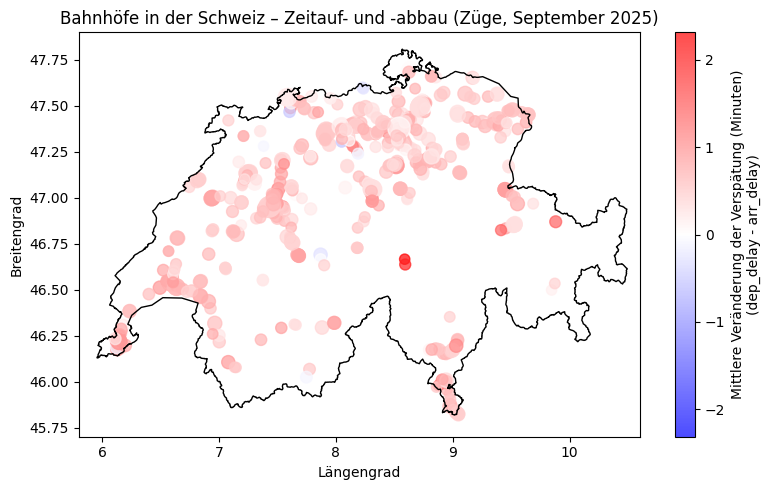

In [15]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

border_path = Path("../data/external/switzerland.geojson")

fig, ax = plt.subplots(figsize=(8, 5))

# 1) Schweiz-Grenze
plot_switzerland_border(
    ax,
    border_path,
    linewidth=1.0,
    color="black",
)

# 2) Farbbereich symmetrisch um 0 wählen,
#    damit blau = Zeit gutmachen, rot = Verspätung
vals = stations_geo["mean_delta_delay_min"].to_numpy()
max_abs = np.nanmax(np.abs(vals))

# 3) Stationen mit blau–weiß–rot einfärben
sc = ax.scatter(
    stations_geo["lon"].to_numpy(),
    stations_geo["lat"].to_numpy(),
    c=vals,
    cmap="bwr",          # blau–weiß–rot
    vmin=-max_abs,       # symmetrisch um 0
    vmax= max_abs,
    s=stations_geo["n_obs"].to_numpy() ** 0.5,
    alpha=0.7,
)

cb = plt.colorbar(
    sc,
    ax=ax,
    label="Mittlere Veränderung der Verspätung (Minuten)\n(dep_delay - arr_delay)",
)

ax.set_xlabel("Längengrad")
ax.set_ylabel("Breitengrad")
ax.set_title("Bahnhöfe in der Schweiz – Zeitauf- und -abbau (Züge, September 2025)")

# Feste, sinnvolle Schweiz-Bounding-Box
ax.set_xlim(5.8, 10.6)
ax.set_ylim(45.7, 47.9)

plt.tight_layout()
plt.show()

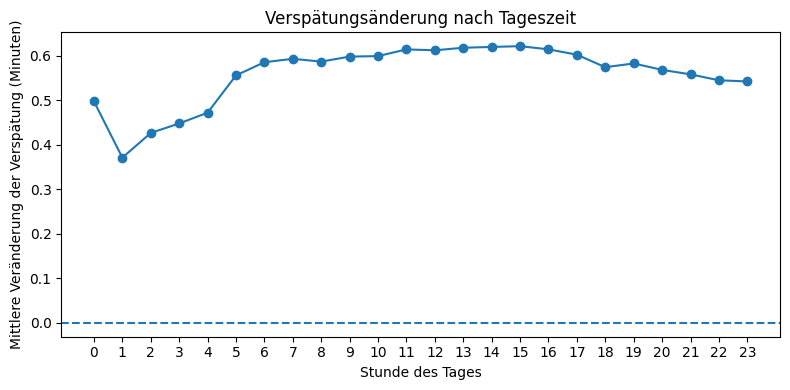

In [16]:
df_trains = df_trains.with_columns([
    pl.col("ANKUNFTSZEIT").dt.hour().alias("hour")
])

hourly = (
    df_trains
    .group_by("hour")
    .agg([
        pl.col("delta_delay_min").mean().alias("mean"),
        pl.col("delta_delay_min").median().alias("median"),
        pl.col("delta_delay_min").count().alias("size")
    ])
    .sort("hour")
)

plt.figure(figsize=(8, 4))
plt.plot(hourly["hour"].to_numpy(), hourly["mean"].to_numpy(), marker="o")
plt.axhline(0, linestyle="--")
plt.xlabel("Stunde des Tages")
plt.ylabel("Mittlere Veränderung der Verspätung (Minuten)")
plt.title("Verspätungsänderung nach Tageszeit")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

border_path = Path("../data/external/switzerland.geojson")

def plot_delay_map_for_day(day_str,
                           df_trains,
                           stops_small,
                           min_obs,
                           max_abs_min):
    """
    Karte der mittleren Verspätungsänderung pro Bahnhof
    für einen Betriebstag (BETRIEBSTAG).

    day_str: z.B. "2025-09-01"
    min_obs: Mindestanzahl Halte pro Station für diesen Tag
    max_abs_min: Farbskala [-max_abs_min, +max_abs_min]
    """

    # 1) Daten für diesen Tag
    df_day = df_trains.filter(pl.col("BETRIEBSTAG") == day_str)
    if df_day.shape[0] == 0:
        print(f"Keine Daten für {day_str}")
        return None

    # 2) Aggregation pro Station (nur dieser Tag)
    agg_day = (
        df_day
        .group_by(["BPUIC", "HALTESTELLEN_NAME"])
        .agg([
            pl.col("delta_delay_min").mean().alias("mean_delta_delay_min"),
            pl.col("delta_delay_min").count().alias("n_obs")
        ])
    )

    # Mindestanzahl Halte
    agg_day = agg_day.filter(pl.col("n_obs") >= min_obs)
    if agg_day.shape[0] == 0:
        print(f"Keine Stationen mit n_obs >= {min_obs} für {day_str}")
        return None

    # 3) Koordinaten joinen
    day_geo = agg_day.join(stops_small, on="BPUIC", how="inner")
    if day_geo.shape[0] == 0:
        print(f"Kein Koordinaten-Match für {day_str}")
        return None

    # 4) Plot
    vals = day_geo["mean_delta_delay_min"].to_numpy()
    max_abs = max_abs_min

    fig, ax = plt.subplots(figsize=(8, 5))

    # Schweiz-Grenze
    plot_switzerland_border(
        ax,
        border_path,
        linewidth=1.0,
        color="black",
    )

    sc = ax.scatter(
        day_geo["lon"].to_numpy(),
        day_geo["lat"].to_numpy(),
        c=vals,
        cmap="bwr",          # oder deine eigene Blau–Rot-Cmap
        vmin=-max_abs,
        vmax= max_abs,
        s=day_geo["n_obs"].to_numpy() ** 0.5,
        alpha=0.7,
    )

    cb = plt.colorbar(
        sc,
        ax=ax,
        label="Mittlere Veränderung der Verspätung (Minuten)\n(dep_delay - arr_delay)",
    )

    ax.set_xlabel("Längengrad")
    ax.set_ylabel("Breitengrad")
    ax.set_title(f"Bahnhöfe – Zeitauf/-abbau am {day_str}")

    ax.set_xlim(5.8, 10.6)
    ax.set_ylim(45.7, 47.9)

    plt.tight_layout()
    plt.show()

    return fig, day_geo

Plot für 01.09.2025
Geometry type: MultiPolygon


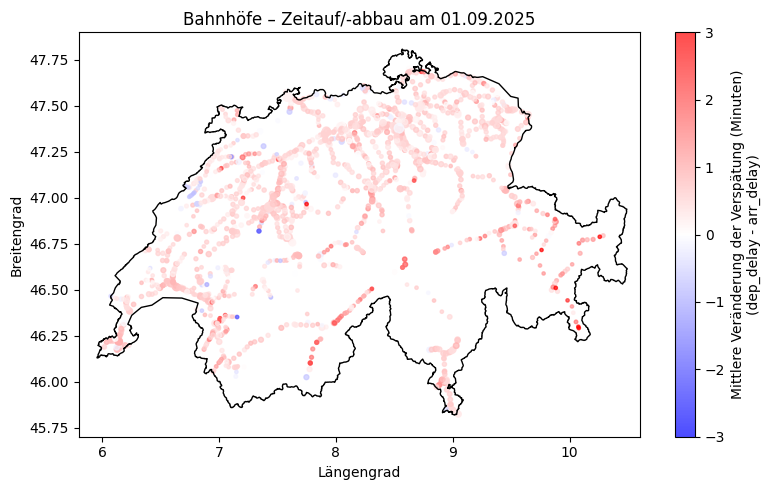

Plot für 02.09.2025
Geometry type: MultiPolygon


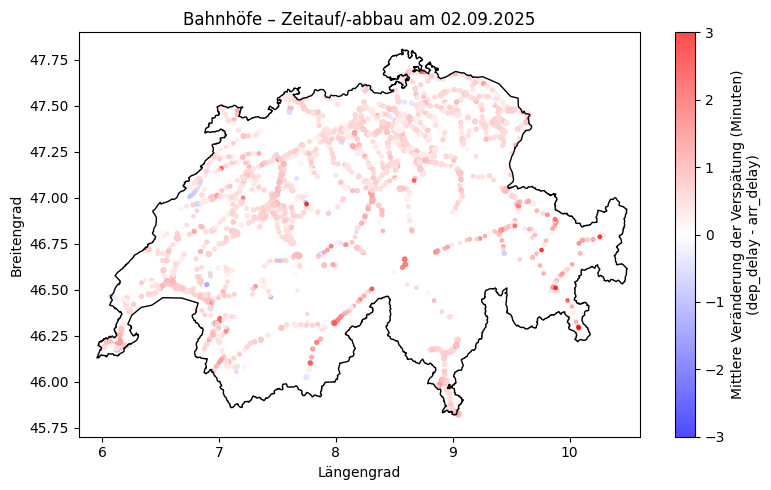

Plot für 03.09.2025
Geometry type: MultiPolygon


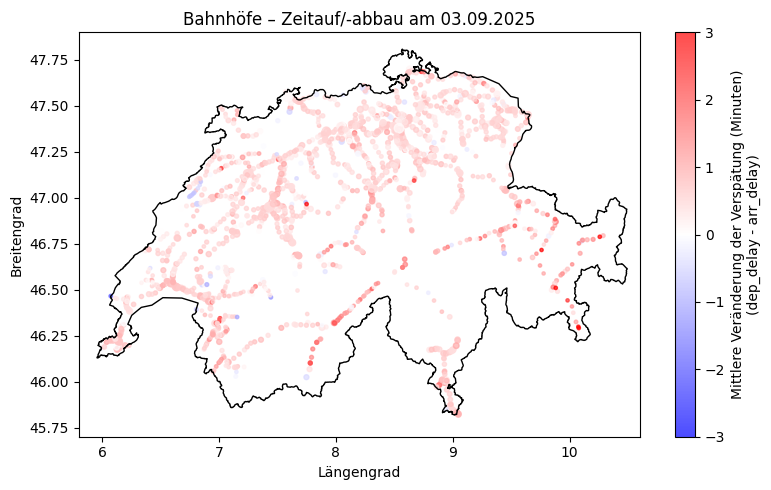

Plot für 04.09.2025
Geometry type: MultiPolygon


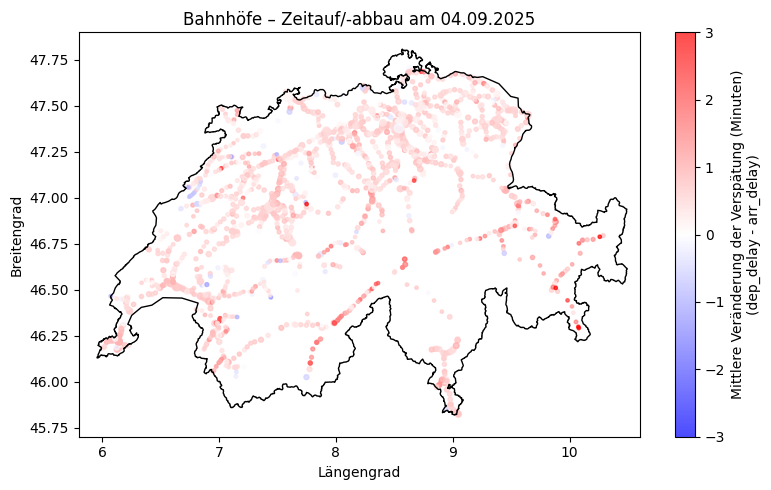

Plot für 05.09.2025
Geometry type: MultiPolygon


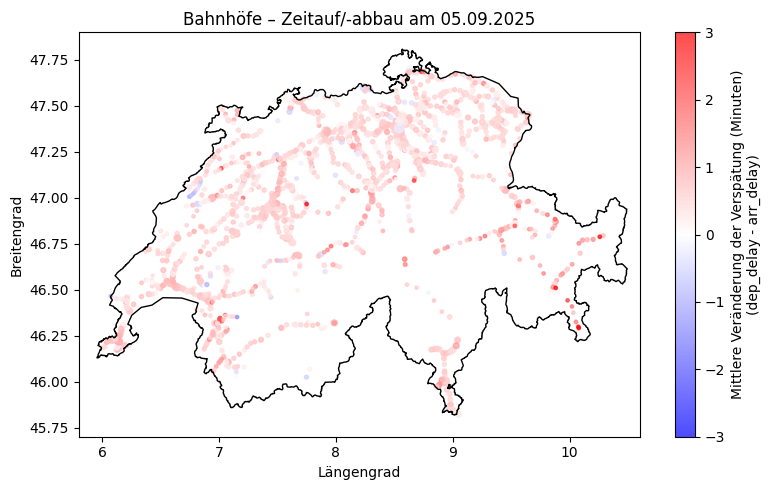

Plot für 06.09.2025
Geometry type: MultiPolygon


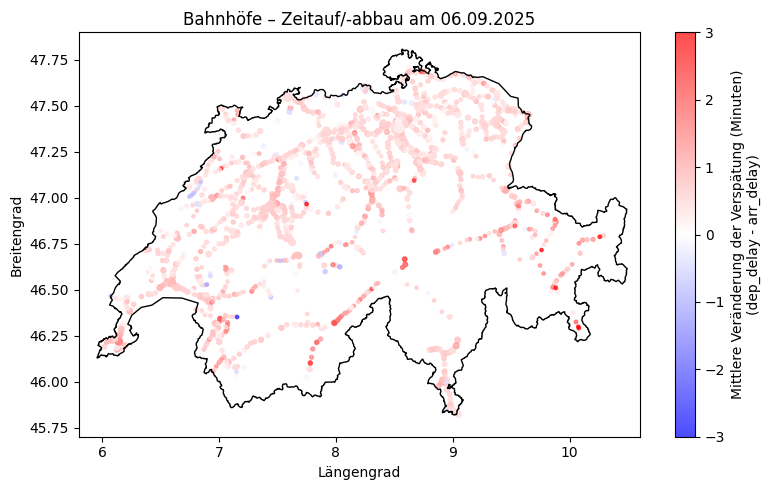

Plot für 07.09.2025
Geometry type: MultiPolygon


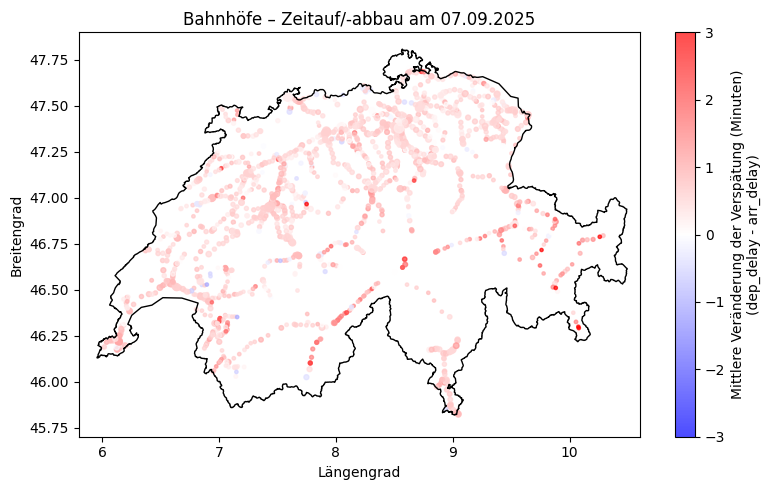

Plot für 08.09.2025
Geometry type: MultiPolygon


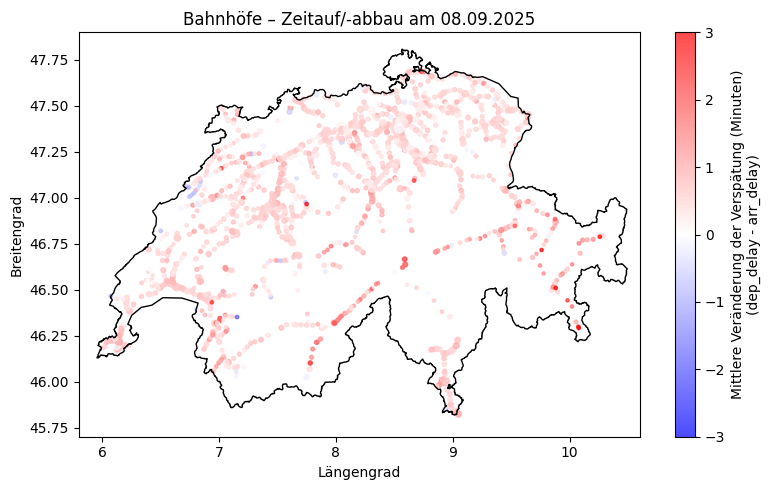

Plot für 09.09.2025
Geometry type: MultiPolygon


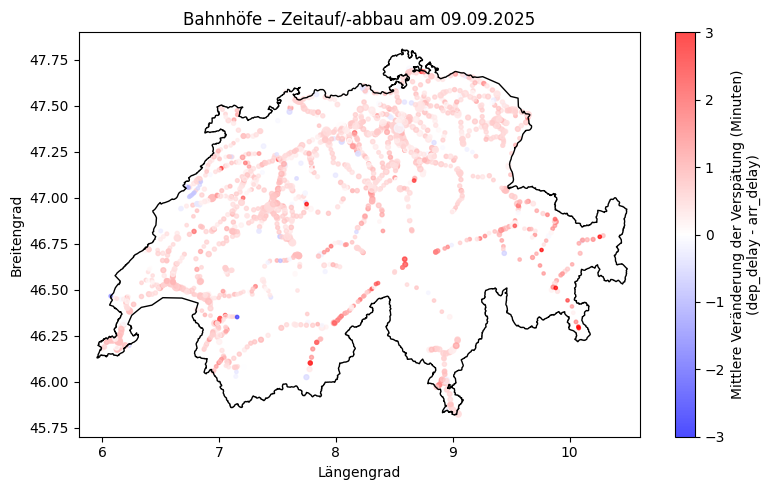

Plot für 10.09.2025
Geometry type: MultiPolygon


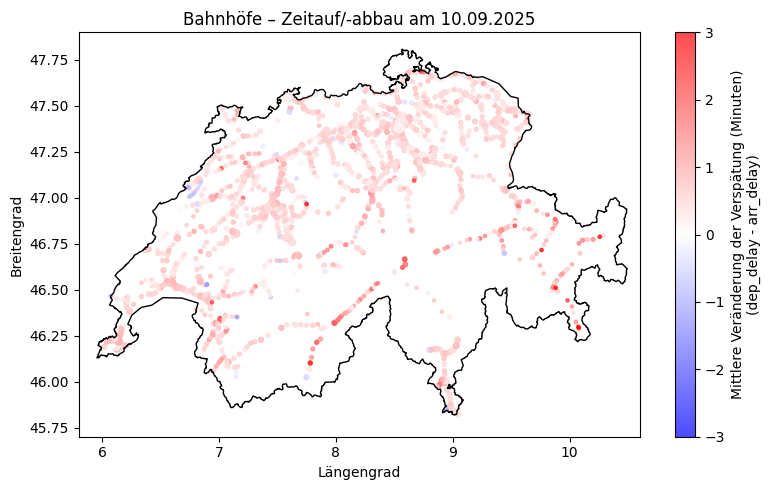

Plot für 11.09.2025
Geometry type: MultiPolygon


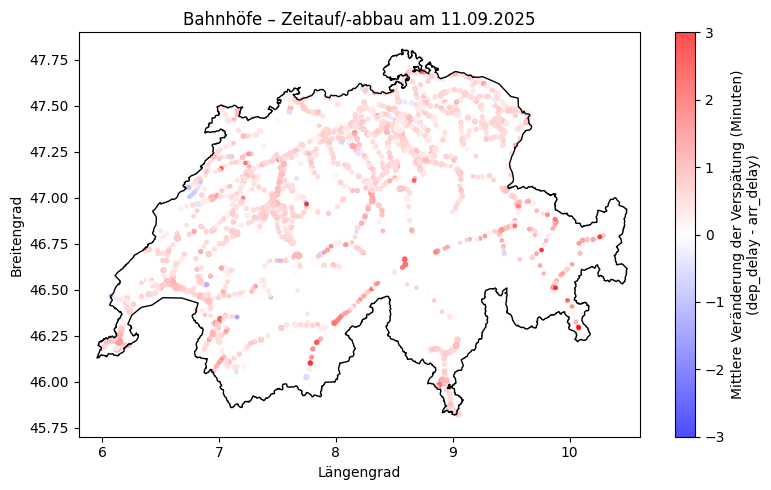

Plot für 12.09.2025
Geometry type: MultiPolygon


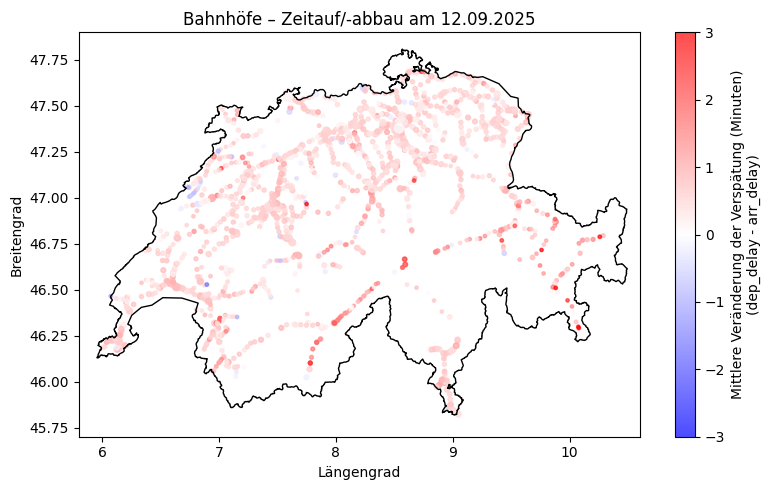

Plot für 13.09.2025
Geometry type: MultiPolygon


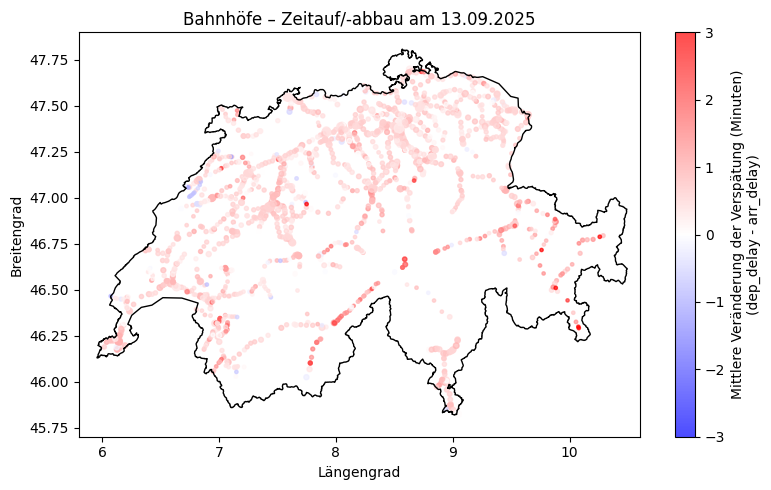

Plot für 14.09.2025
Geometry type: MultiPolygon


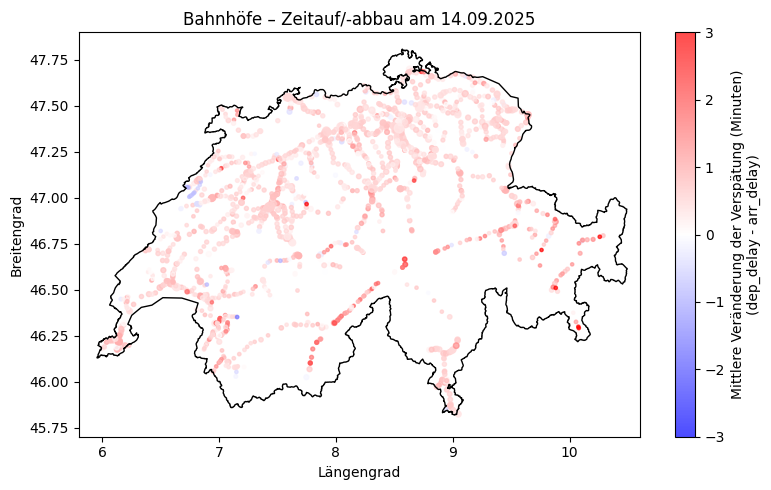

Plot für 15.09.2025
Geometry type: MultiPolygon


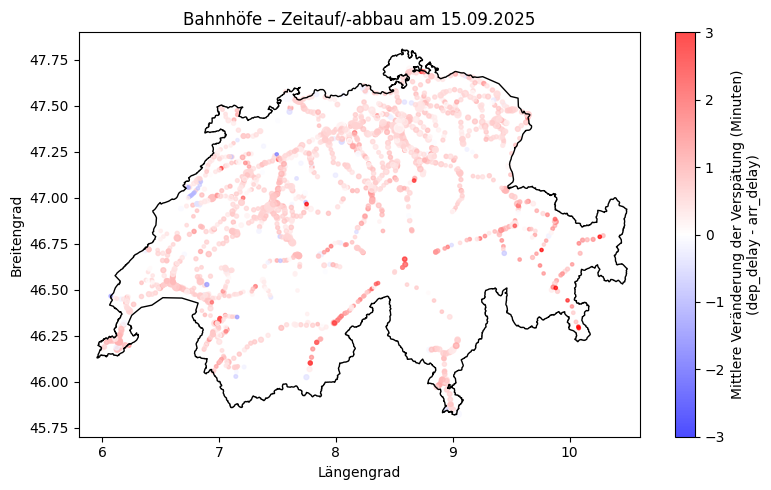

Plot für 16.09.2025
Geometry type: MultiPolygon


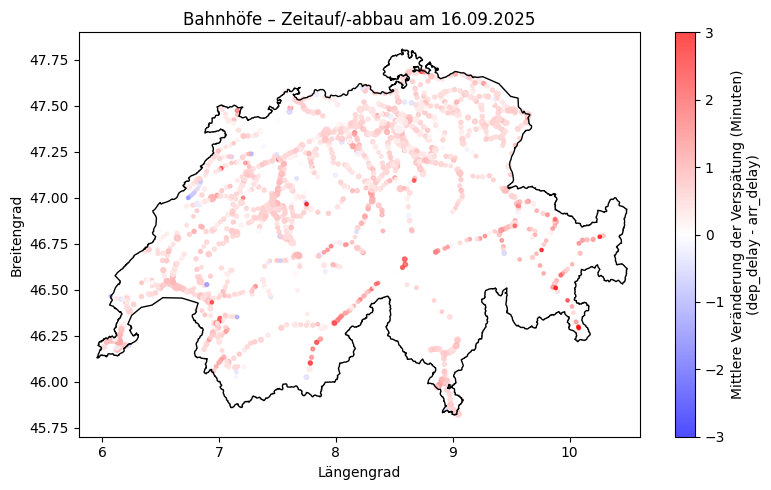

Plot für 17.09.2025
Geometry type: MultiPolygon


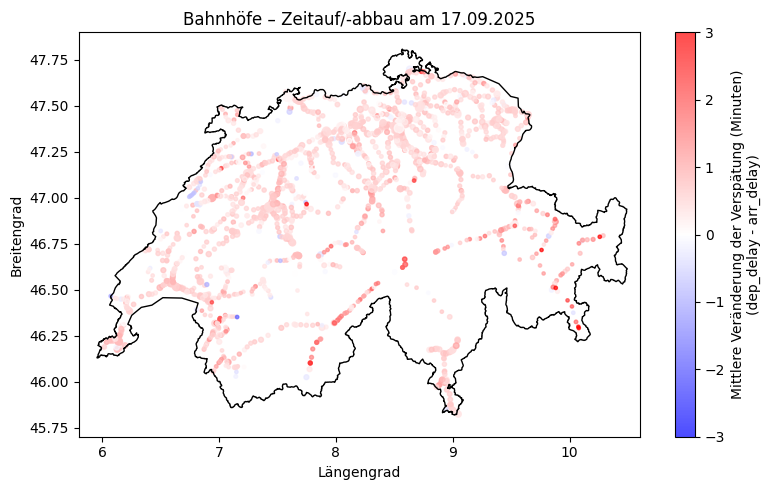

Plot für 18.09.2025
Geometry type: MultiPolygon


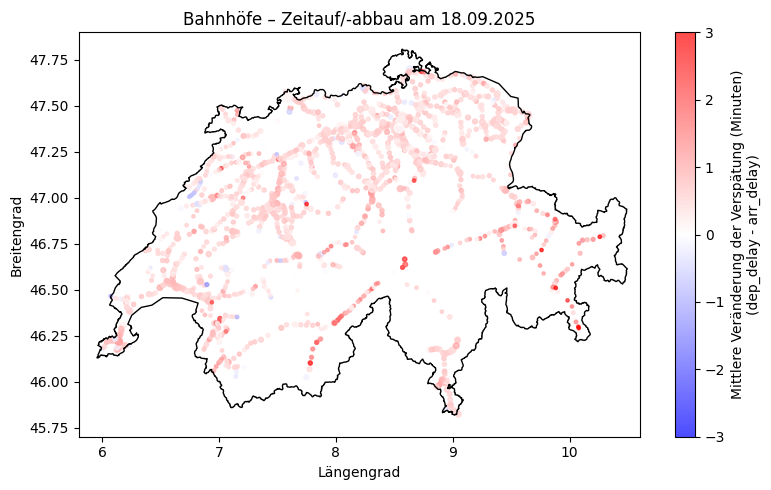

Plot für 19.09.2025
Geometry type: MultiPolygon


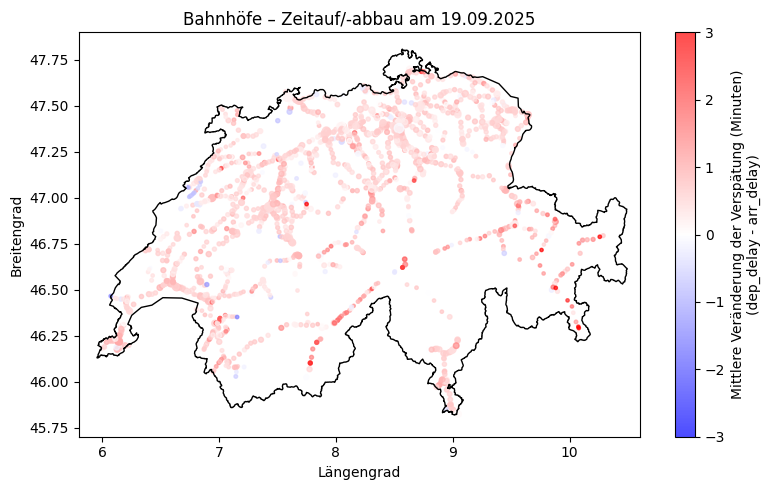

Plot für 20.09.2025
Geometry type: MultiPolygon


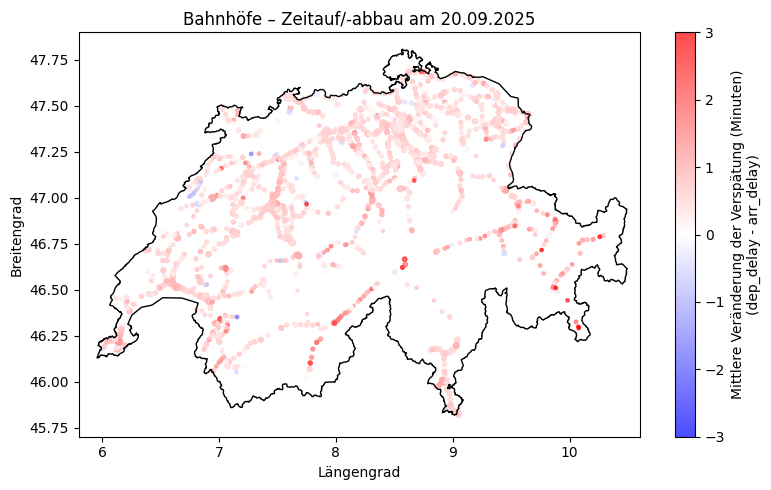

Plot für 21.09.2025
Geometry type: MultiPolygon


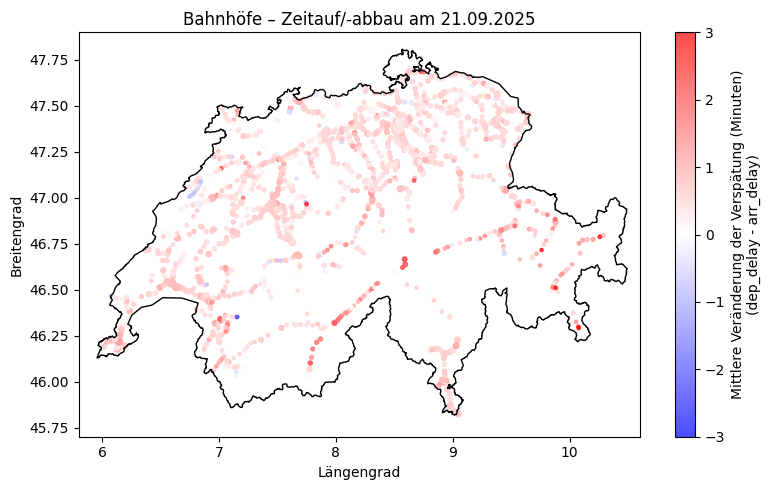

Plot für 22.09.2025
Geometry type: MultiPolygon


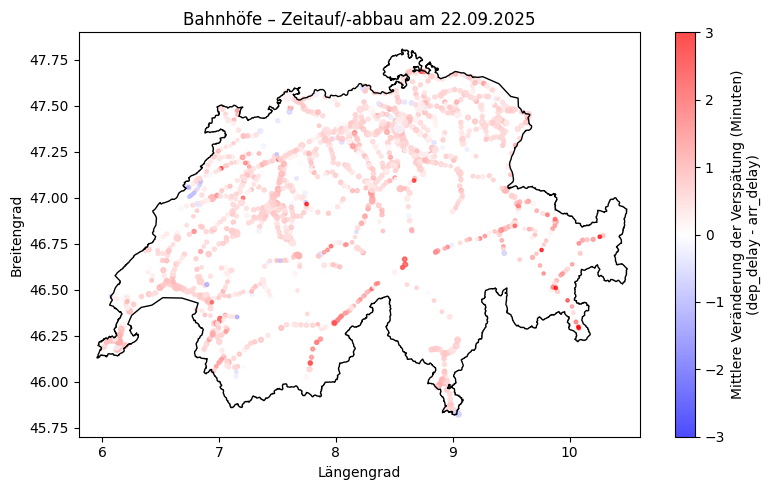

Plot für 23.09.2025
Geometry type: MultiPolygon


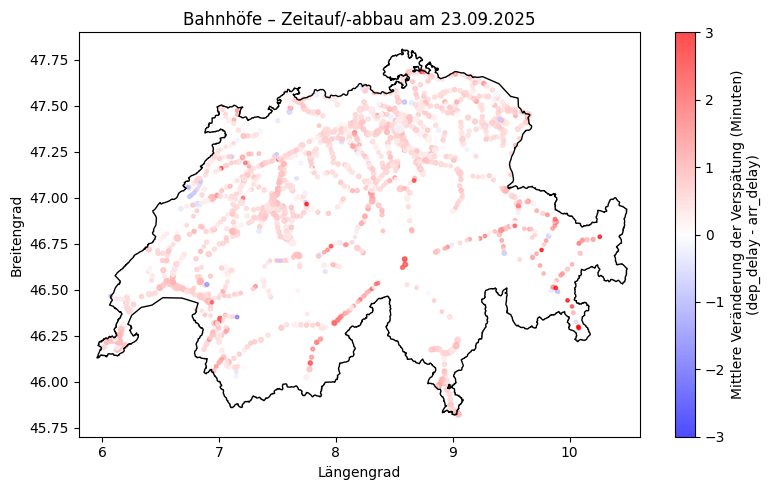

Plot für 24.09.2025
Geometry type: MultiPolygon


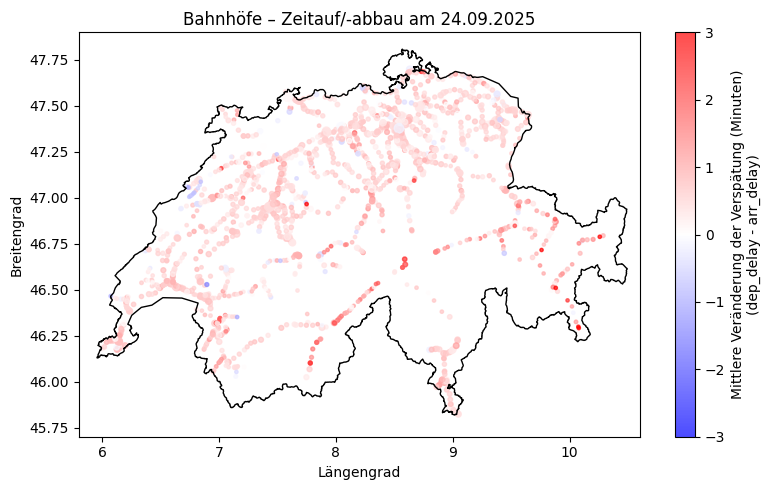

Plot für 25.09.2025
Geometry type: MultiPolygon


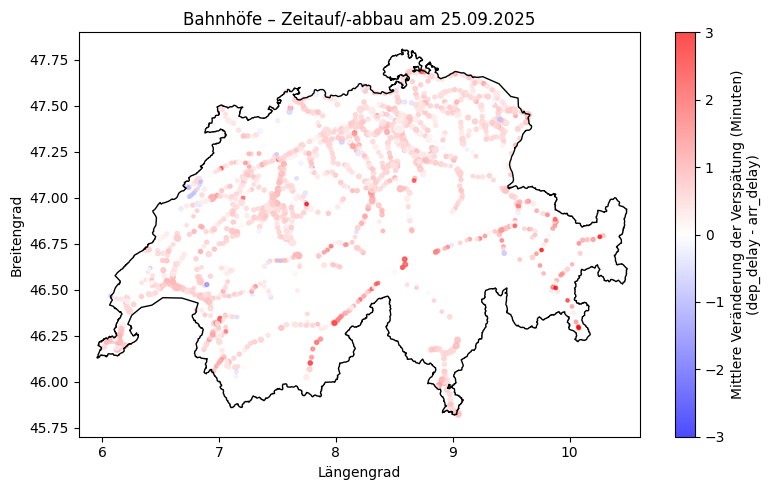

Plot für 26.09.2025
Geometry type: MultiPolygon


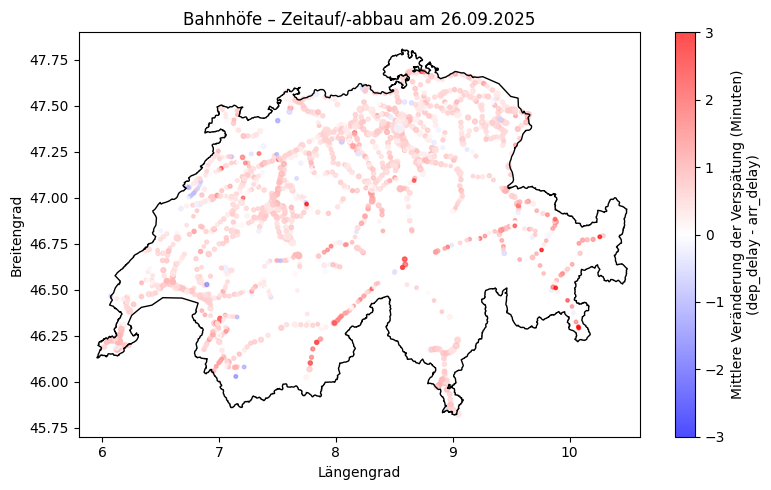

Plot für 27.09.2025
Geometry type: MultiPolygon


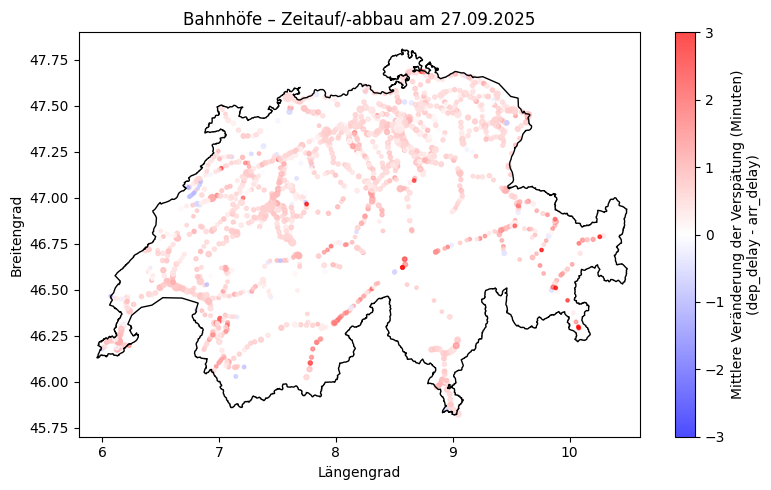

Plot für 28.09.2025
Geometry type: MultiPolygon


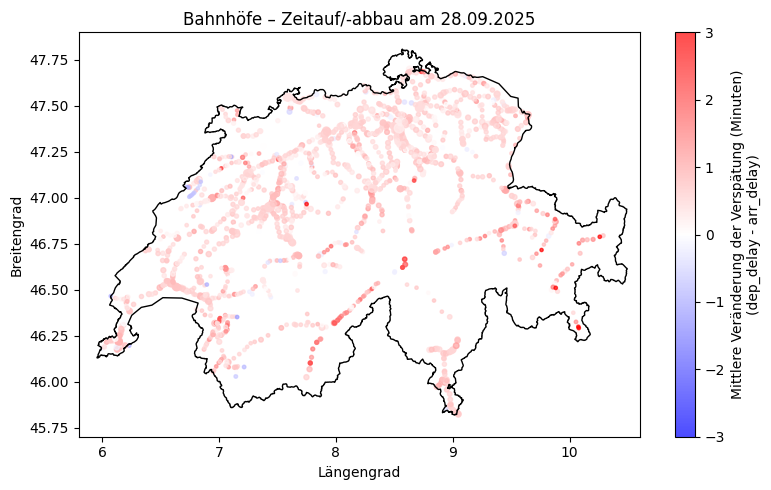

Plot für 29.09.2025
Geometry type: MultiPolygon


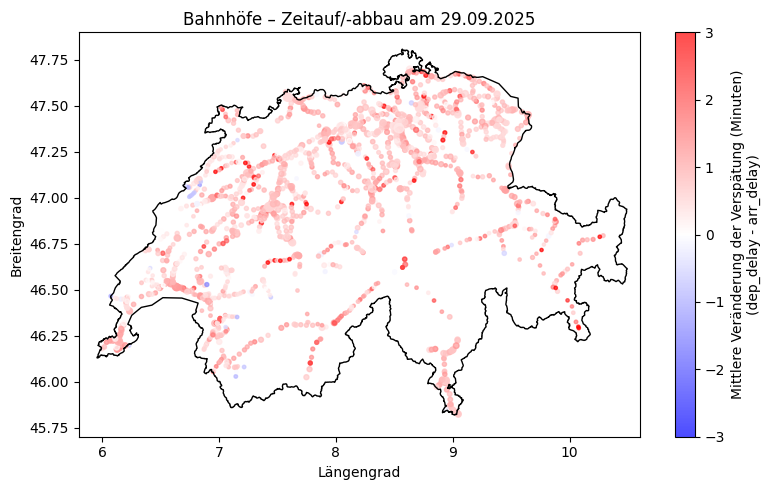

Plot für 30.09.2025
Geometry type: MultiPolygon


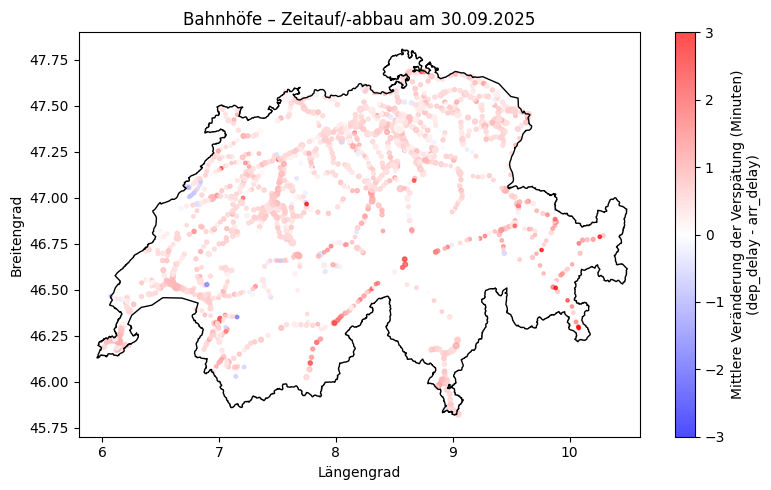

In [18]:
unique_days = sorted(df_trains["BETRIEBSTAG"].unique().to_list())

for day_str in unique_days:
    print("Plot für", day_str)

    plot_delay_map_for_day(
        day_str,
        df_trains,
        stops_small,
        min_obs=30,
        max_abs_min=3.0,
    )